## Preliminaries

In [2]:
!pip install pytorch-pretrained-bert pytorch-nlp

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn.utils import shuffle

In [1]:
%tensorflow_version 1.x
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

TensorFlow 1.x selected.
Found GPU at: /device:GPU:0


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

In [6]:
# Data can be found at https://github.com/ldselvera/troll_detector/tree/master/data
# Upload the train data-1: nontrolls.csv
from google.colab import files
uploaded = files.upload()

Saving csv-zusammenfuehren.de_3mjg6fs7.csv to csv-zusammenfuehren.de_3mjg6fs7.csv


In [7]:
# Upload the train data-2: trolls.csv
from google.colab import files
uploaded = files.upload()

Saving comments.csv to comments.csv


## Data Import

In [8]:
pd.set_option('display.max_colwidth', -1)

#Reading in Non_Russians data set
Non_Russian=pd.read_csv("nontrolls.csv", error_bad_lines=False)
#Reading in comments by Russian Trolls
Russian = pd.read_csv("trolls.csv")

#Get only the comments
Non_Russian = Non_Russian[["body"]]
Russian = Russian[["body"]]

#Dropping rows with N/A
Non_Russian.dropna(inplace=True)
Russian.dropna(inplace=True)

Non_Russian.style.set_properties(subset=['body'], **{'width': '500'})
Russian.style.set_properties(subset=['body'], **{'width': '500px'})

num_samples = Russian.shape[0]
Non_Russian = Non_Russian.sample(num_samples)

b'Skipping line 4581: expected 20 fields, saw 22\nSkipping line 9684: expected 20 fields, saw 21\nSkipping line 11215: expected 20 fields, saw 27\n'
b'Skipping line 33342: expected 20 fields, saw 21\nSkipping line 38620: expected 20 fields, saw 22\nSkipping line 40411: expected 20 fields, saw 21\n'
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
Russian.head(10)

,body
0,"A hard look at training and tactics"" = They will be sent more $$$ for ""training"""
1,They deserve all of the hate
2,"I guess that's what they mean when say ""I don't see color"""
3,"It's never too late for them, It's never too cruel or brutal for them. He will still probably get away with this"
4,https://petitions.whitehouse.gov//petition/petition-create-nationwide-elected-and-publicly-reviewed-police-oversight-agency
5,"By submitting to an independent, non-profit community, the authors volunteered on a Good Samaritan basis to spread wokeness"
6,"Sorry, but if you bothered to read the article below the video you could've gotten the point"
7,That is not a personal blog
8,"Only 125? Why not 10?\r\nIslamic state has captured half Syria, they are close to Baghdad and keep advancing while all western leaders do is simply taking some minor measures. Smh"
9,What? Any other wild guesses about my private life?


In [16]:
Non_Russian.head(10)

,body
22618,Why not a Triad?
9742,"Yeah, and It kinda did to you too"
30227,"Well, there's also the Julian Assange show on RT:\nhttps://www.rt.com/tags/the-julian-assange-show/\nThis tweet on November 3rd - during early voting and 4 days before election - from wikileaks saying ""significant if partisan"" about pizza gate:\nhttps://twitter.com/wikileaks/status/794247777756860417?lang=en\nAnd you may note that the first link in that reddit post proving a long relationship with a sketchy person is this link, dated from 2001, 9 years before the earthquake: (But the date stamp is false: this document is from 2010 as made clear by the fact it references the earthquake that happened in Dec 2009): \nhttps://wikileaks.org/clinton-emails/emailid/3776\nSo wikileaks tweeting about a very shoddily-sourced (from their own material) fake news story on information they released, in combination with those leaks being strategically released right before the election, combined with Assange claiming back in 2006 he was going to take Russia down, but then not ever moving forward on releasing anti-Russian documents after Putin started aiding him against his rape charges:\nhttp://www.nytimes.com/2016/09/01/world/europe/wikileaks-julian-assange-russia.html?_r=0"
11674,"Tomahawks were Black Ops, you FUCKING SCRUB NOOB."
44796,"But without spending trillions on our military, how are we going to deal with ISIS?! Because if we let our guard down for a second, a small group of terrorists using homemade explosives and decades-old weapons will overthrow the most powerful country in the world! /s"
38044,dab game HEAVY right off the bat
28607,Have the Pats currently.. is it actually worth dropping them for the Fins? I'm worried someone else would pick them up since I don't have the bench space to keep two DEFs. Thoughts?
29976,"It's just a quote from a philosopher, I wouldn't read into it too much.\nhttps://www.brainyquote.com/quotes/quotes/w/waynedyer718015.html"
21094,sent for misty
10312,"Alistair would be blue for loyalty with gold lettering for royalty. And his crit would be red, for love and white, for purity."


## Data Preprocessing

In [0]:
# Create sentence and label lists
Russian_sentences = Russian.body.values
Non_Russian_sentences = Non_Russian.body.values

# Special initial and EOS (end of sentence) tokens
Russian_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in Russian_sentences]
Non_Russian_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in Non_Russian_sentences]
Non_Russian_sentences[0]

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Russian_tokenized_texts = [tokenizer.tokenize(sent) for sent in Russian_sentences]
Non_Russian_tokenized_texts = [tokenizer.tokenize(sent) for sent in Non_Russian_sentences]

Russian_tokenized_texts = [x for x in Russian_tokenized_texts if len(x) < 128]
Non_Russian_tokenized_texts = [x for x in Non_Russian_tokenized_texts if len(x) < 128]

tokenized_texts = Non_Russian_tokenized_texts + Russian_tokenized_texts

print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 421377.95B/s]


Tokenize the first sentence:
['[CLS]', 'why', 'not', 'a', 'triad', '?', '[SEP]']


In [0]:
#Adding Labels
Non_Russian_labels = [0 for x in range(len(Non_Russian_tokenized_texts))]
Russian_labels = [1 for x in range(len(Russian_tokenized_texts))]

labels = Non_Russian_labels + Russian_labels

In [0]:
# Max sequence length.
MAX_LEN = 128
# BERT tokenizer 
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [0]:
# Create attention masks
attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [0]:
# Split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.1)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
# Iterator of data
batch_size = 32
epochs = 4
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

## Load BERT model

In [19]:
# Load pretrained BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
# Hyperparemeter information
optimizer = BertAdam(optimizer_grouped_parameters, lr=2e-5, warmup=.1)

100%|██████████| 407873900/407873900 [00:32<00:00, 12392539.18B/s]
t_total value of -1 results in schedule not being applied


In [0]:
# Calculate the accuracy of predictions
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

## Training

In [21]:
# Training
t = [] 
train_loss_set = []

# tqdm wrapper range
for _ in trange(epochs, desc="Epoch"):


    # Training
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss.item())    
        loss.backward()
        optimizer.step()
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))


    # Validation
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.5279712812392005


Epoch:  25%|██▌       | 1/4 [09:12<27:36, 552.24s/it]

Validation Accuracy: 0.7583841463414634
Train loss: 0.303602174234027


Epoch:  50%|█████     | 2/4 [18:24<18:24, 552.25s/it]

Validation Accuracy: 0.7644817073170732
Train loss: 0.12285771506768844


Epoch:  75%|███████▌  | 3/4 [27:37<09:12, 552.38s/it]

Validation Accuracy: 0.7827743902439024
Train loss: 0.05032772343306495


Epoch: 100%|██████████| 4/4 [36:49<00:00, 552.46s/it]

Validation Accuracy: 0.7629573170731707


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
model.eval()
#Export trained model
torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/model.pt')

## Results

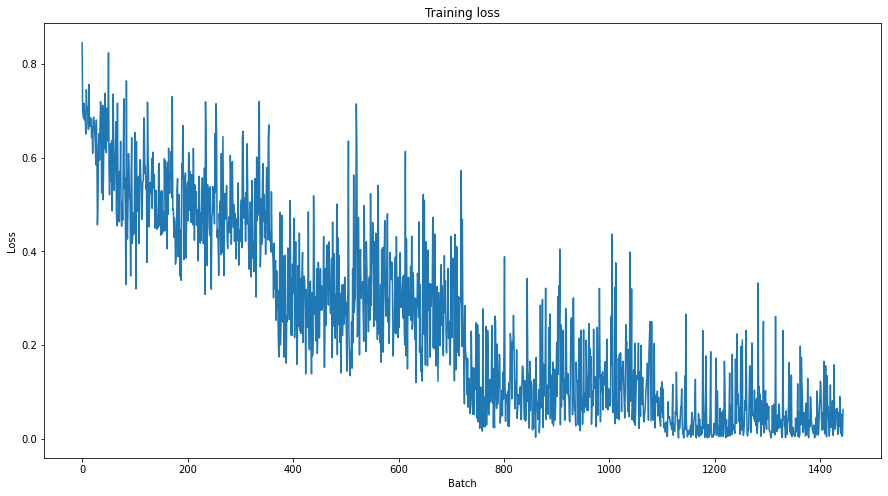

In [26]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()